# Script to plot average causal effects

This script loads sets of hundreds of causal traces that have been computed by the
`experiment.causal_trace` program, and then aggregates the results to compute
Average Indirect Effects and Average Total Effects as well as some other information.


In [10]:
# for testing
import sys

Average Probability of Correct Object Prediction in Clean Runs 0.27013204
Average Probability of Correct Object Prediction in Corrupted Runs 0.08607833212793614
Average Total Effect 0.1840537028890774
Best average indirect effect on last subject 0.01567320400296901
Best average indirect effect on last token 0.07969541722356532
Average best-fixed score 0.19397467
Average best-fixed on last subject token score 0.13045895
Average best-fixed on last token/layer 32 score 0.16577373
Average best-fixed on last token/layer 33 score 0.16533571
Average best-fixed on last word score 0.18542802
Argmax at last subject token 0
Max at last subject token 0.101751536
Argmax at last prompt token 32
Max at last prompt token 0.16577375


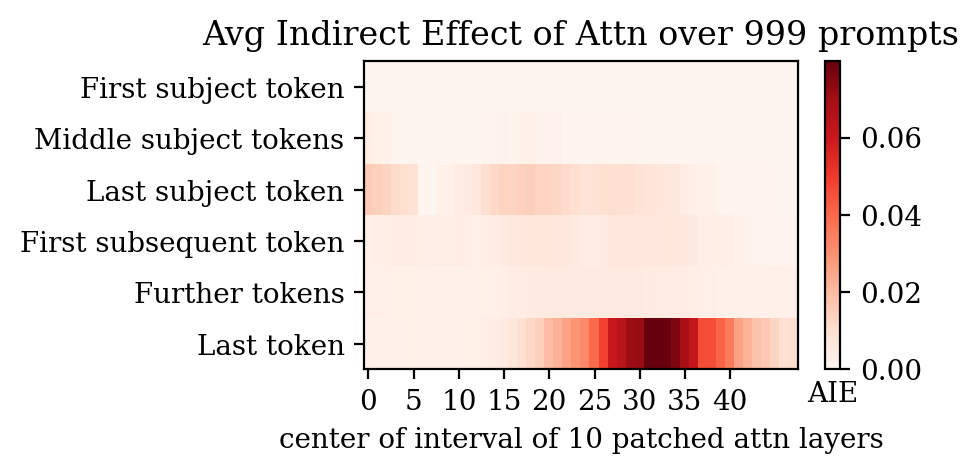

In [16]:
import numpy, os
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "DeJavu serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# Uncomment the architecture to plot.
# arch = "gpt2-xl"
# arch = "ns3_r0_gpt2-xl"
arch = "n0.1_r0_gpt2-xl"
archname = "GPT-2-XL"

# arch = 'EleutherAI_gpt-j-6B'
# archname = 'GPT-J-6B'

# arch = 'EleutherAI_gpt-neox-20b'
# archname = 'GPT-NeoX-20B'


class Avg:
    def __init__(self):
        self.d = []

    def add(self, v):
        # v[None] : adds a new dimension of length 1
        # note: in the case of a numpy scalar, this would result in a 1-D numpy array with 1 element
        self.d.append(v[None])

    def add_all(self, vv):
        self.d.append(vv)

    def avg(self):
        # for testing
        # print(self.d)
        # print(numpy.concatenate(self.d))
        # print(numpy.concatenate(self.d).mean(axis=0).shape)
        # sys.exit(1)

        return numpy.concatenate(self.d).mean(axis=0)

    def std(self):
        return numpy.concatenate(self.d).std(axis=0)

    def size(self):
        return sum(datum.shape[0] for datum in self.d)


def read_knowlege(count=150, kind=None, arch="gpt2-xl"):
    # dirname = f"/results/{arch}/causal_trace/cases"
    dirname = f"/home/smille20/rome/rome/results/{arch}/causal_trace/cases"
    kindcode = "" if not kind else f"_{kind}"
    (
        avg_fe,
        avg_ee,
        avg_le,
        avg_fa,
        avg_ea,
        avg_la,
        avg_hs,
        avg_ls,
        avg_fs,
        avg_fle,
        avg_fla,
    ) = [Avg() for _ in range(11)]

    # iterate over each sample prompt
    for i in range(count):
        try:
            # data = numpy.load(f"{dirname}/knowledge_{i}_{kindcode}.npz")
            data = numpy.load(f"{dirname}/knowledge_{i}{kindcode}.npz")
        except:
            continue
        # Only consider cases where the model begins with the correct prediction
        if "correct_prediction" in data and not data["correct_prediction"]:
            continue

        # probability of predicting the correct object in the corrupted-with-restoration runs (type numpy array)
        # [# of tokens in input prompt, # of model's layers]
        scores = data["scores"]

        # for testing
        # the output results dictionary from causal_trace.py
        # keys of the loaded .npz file: ['scores', 'low_score', 'high_score', 'input_ids', 'input_tokens', 'subject_range',
        #                                'answer', 'window', 'correct_prediction', 'kind']
        # keys = [key for key in data.keys()]
        # print(keys)

        # index of first subject token, index of first token following the last subject token
        first_e, first_a = data["subject_range"]

        # index of last subject token
        last_e = first_a - 1

        # index of last prompt token
        last_a = len(scores) - 1

        # original prediction
        avg_hs.add(data["high_score"])

        # prediction after subject is corrupted
        avg_ls.add(data["low_score"])

        # maximum probability of correct object prediction from corrupted-with-restoration runs
        avg_fs.add(scores.max())

        # some maximum computations

        # for last subject token (in this case, max() returns a scalar)
        avg_fle.add(scores[last_e].max())

        # # for testing
        # print(scores[last_e].max().shape)
        # print(numpy.argmax(scores[last_e]))

        # for last prompt token
        avg_fla.add(scores[last_a].max())

        # First subject middle, last subject.

        # probs of correct object prediction from corrupted-with-restoration runs 
        # for combinations containing first subject token (and all model layers)
        avg_fe.add(scores[first_e])

        # probs of correct object prediction from corrupted-with-restoration runs 
        # for combinations containing an element from the set(second subject token, ..., last subject token)
        # (and all model layers)
        avg_ee.add_all(scores[first_e + 1 : last_e])

        # probs of correct object prediction from corrupted-with-restoration runs 
        # for combinations containing last subject token (and all model layers)
        avg_le.add(scores[last_e])


        # First after, middle after, last after

        # probs of correct object prediction from corrupted-with-restoration runs 
        # for combinations containing first token after the subject (and all model layers)
        avg_fa.add(scores[first_a])

        # probs of correct object prediction from corrupted-with-restoration runs 
        # for combinations containing an element from the set(second token after subject, ..., last prompt token)
        # (and all model layers)
        avg_ea.add_all(scores[first_a + 1 : last_a])

        # probs of correct object prediction from corrupted-with-restoration runs 
        # for combinations containing last prompt token (and all model layers)     
        avg_la.add(scores[last_a])

    result = numpy.stack(
        [
            avg_fe.avg(),
            avg_ee.avg(),
            avg_le.avg(),
            avg_fa.avg(),
            avg_ea.avg(),
            avg_la.avg(),
        ]
    )
    result_std = numpy.stack(
        [
            avg_fe.std(),
            avg_ee.std(),
            avg_le.std(),
            avg_fa.std(),
            avg_ea.std(),
            avg_la.std(),
        ]
    )

    print("Average Probability of Correct Object Prediction in Clean Runs", avg_hs.avg())
    print("Average Probability of Correct Object Prediction in Corrupted Runs", avg_ls.avg())


    print("Average Total Effect", avg_hs.avg() - avg_ls.avg())

    print(
        "Best average indirect effect on last subject",
        avg_le.avg().max() - avg_ls.avg(),
    )

    print(
        "Best average indirect effect on last token", avg_la.avg().max() - avg_ls.avg()
    )
    print("Average best-fixed score", avg_fs.avg())
    print("Average best-fixed on last subject token score", avg_fle.avg())

    # added
    if kind == None:
        print("Average best-fixed on last subject token/layer 14 score", numpy.concatenate(avg_le.d)[:, 14].mean())
    if kind == 'mlp':
        print("Average best-fixed on last subject token/layer 16 score", numpy.concatenate(avg_le.d)[:, 16].mean())
    if kind == 'attn':
        print("Average best-fixed on last token/layer 32 score", numpy.concatenate(avg_la.d)[:, 32].mean())
        print("Average best-fixed on last token/layer 33 score", numpy.concatenate(avg_la.d)[:, 33].mean())

    print("Average best-fixed on last word score", avg_fla.avg())
    print("Argmax at last subject token", numpy.argmax(avg_le.avg()))
    print("Max at last subject token", numpy.max(avg_le.avg()))
    print("Argmax at last prompt token", numpy.argmax(avg_la.avg()))
    print("Max at last prompt token", numpy.max(avg_la.avg()))
    return dict(
        low_score=avg_ls.avg(), result=result, result_std=result_std, size=avg_fe.size()
    )


def plot_array(
    differences,
    kind=None,
    savepdf=None,
    title=None,
    low_score=None,
    high_score=None,
    archname="GPT2-XL",
):
    if low_score is None:
        low_score = differences.min()
    if high_score is None:
        high_score = differences.max()
    answer = "AIE"
    labels = [
        "First subject token",
        "Middle subject tokens",
        "Last subject token",
        "First subsequent token",
        "Further tokens",
        "Last token",
    ]

    fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
    h = ax.pcolor(
        differences,
        cmap={None: "Purples", "mlp": "Greens", "attn": "Reds"}[kind],
        vmin=low_score,
        vmax=high_score,
    )
    if title:
        ax.set_title(title)
    ax.invert_yaxis()
    ax.set_yticks([0.5 + i for i in range(len(differences))])
    ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
    ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
    ax.set_yticklabels(labels)
    if kind is None:
        ax.set_xlabel(f"single patched layer within {archname}")
    else:
        ax.set_xlabel(f"center of interval of 10 patched {kind} layers")
    cb = plt.colorbar(h)
    # The following should be cb.ax.set_xlabel(answer), but this is broken in matplotlib 3.5.1.
    if answer:
        cb.ax.set_title(str(answer).strip(), y=-0.16, fontsize=10)

    if savepdf:
        os.makedirs(os.path.dirname(savepdf), exist_ok=True)
        plt.savefig(savepdf, bbox_inches="tight")
    plt.show()


# the_count = 1209
# the_count = 1001
the_count = 1000
high_score = None  # Scale all plots according to the y axis of the first plot

for kind in [None, "mlp", "attn"]:
# # for testing
# for kind in ['attn']:
    d = read_knowlege(the_count, kind, arch)
    count = d["size"]
    what = {
        None: "Indirect Effect of $h_i^{(l)}$",
        "mlp": "Indirect Effect of MLP",
        "attn": "Indirect Effect of Attn",
    }[kind]

    title = f"Avg {what} over {count} prompts"
    result = numpy.clip(d["result"] - d["low_score"], 0, None)
    kindcode = "" if kind is None else f"_{kind}"
    if kind not in ["mlp", "attn"]:
        high_score = result.max()
    plot_array(
        result,
        kind=kind,
        title=title,
        low_score=0.0,
        high_score=high_score,
        archname=archname,
        savepdf=f"results/{arch}/causal_trace/summary_pdfs/rollup{kindcode}.pdf",
    )

In [12]:
cwd = os.getcwd()
print(cwd)

/home/smille20/rome/rome/notebooks


## Plot line graph

To make confidence intervals visible, we plot the data as line graphs below.

Reading None
Average Probability of Correct Object Prediction in Clean Runs 0.27013204
Average Probability of Correct Object Prediction in Corrupted Runs 0.08607833212793614
Average Total Effect 0.1840537028890774
Best average indirect effect on last subject 0.08717638128816341
Best average indirect effect on last token 0.1840539413076565
Average best-fixed score 0.2908234
Average best-fixed on last subject token score 0.19685501
Average best-fixed on last subject token/layer 14 score 0.17325465
Average best-fixed on last word score 0.2827168
Argmax at last subject token 14
Max at last subject token 0.17325471
Argmax at last prompt token 47
Max at last prompt token 0.27013227
Reading mlp
Average Probability of Correct Object Prediction in Clean Runs 0.27013204
Average Probability of Correct Object Prediction in Corrupted Runs 0.08607833212793614
Average Total Effect 0.1840537028890774
Best average indirect effect on last subject 0.06605599695264552
Best average indirect effect on last 

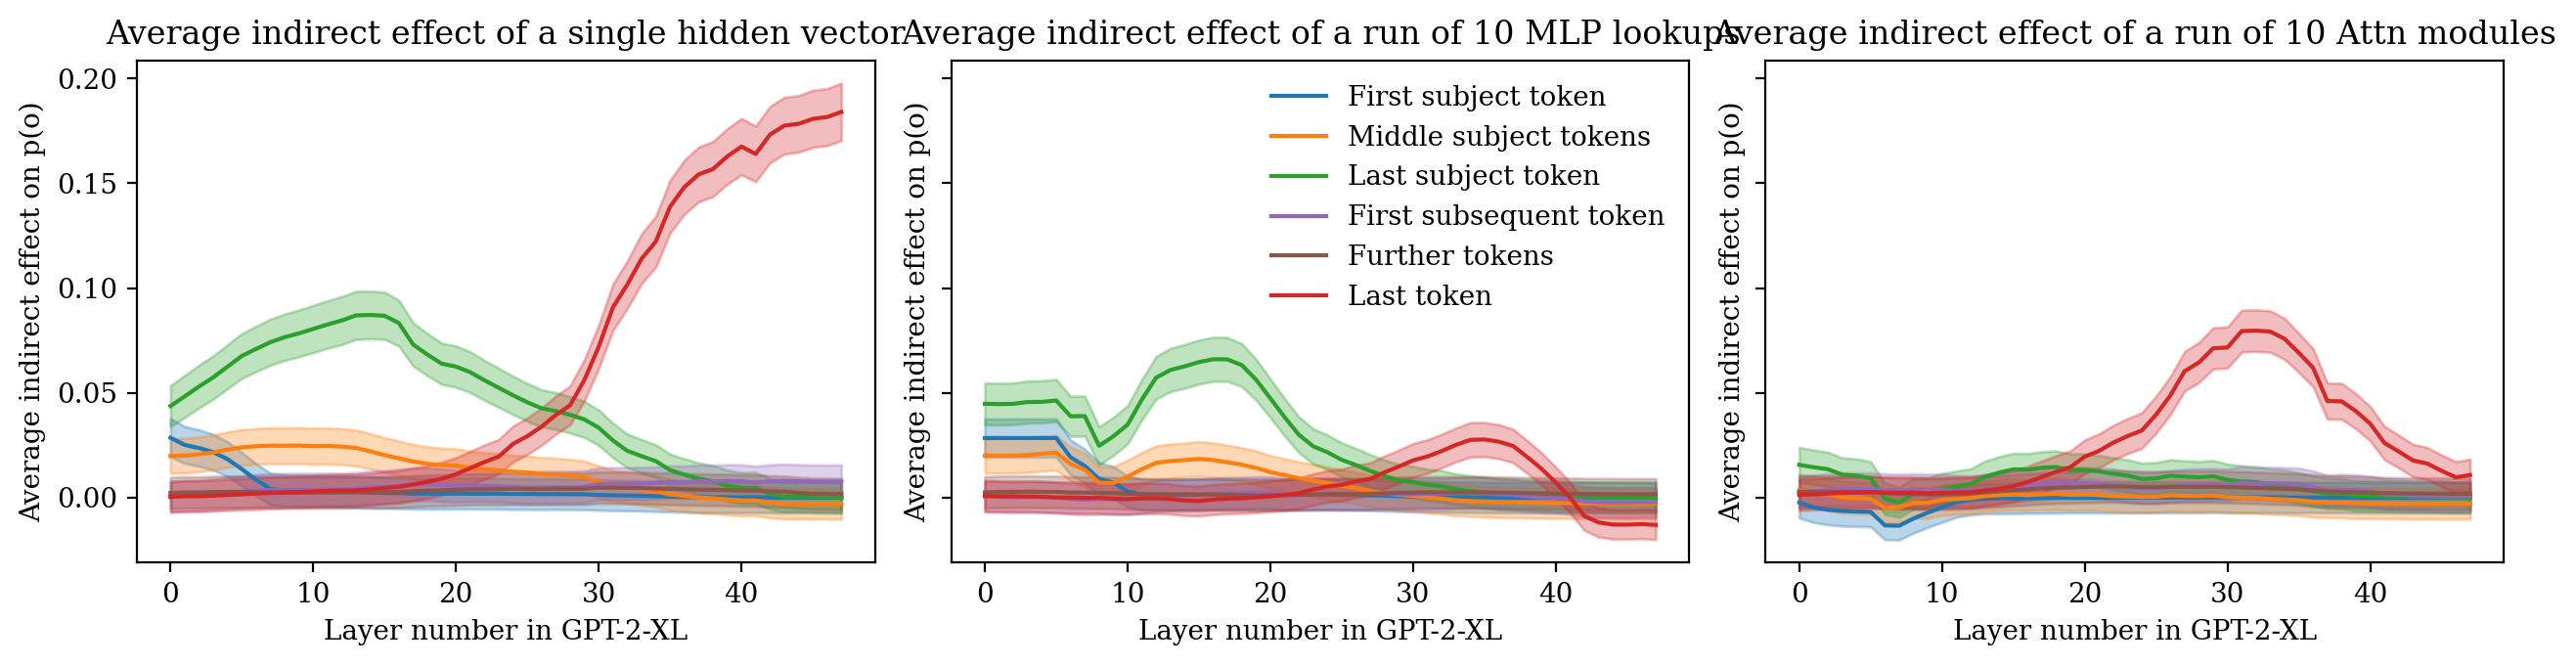

In [13]:
import math

labels = [
    "First subject token",
    "Middle subject tokens",
    "Last subject token",
    "First subsequent token",
    "Further tokens",
    "Last token",
]
color_order = [0, 1, 2, 4, 5, 3]
x = None

cmap = plt.get_cmap("tab10")
fig, axes = plt.subplots(1, 3, figsize=(13, 3.5), sharey=True, dpi=200)
for j, (kind, title) in enumerate(
    [
        (None, "single hidden vector"),
        ("mlp", "run of 10 MLP lookups"),
        ("attn", "run of 10 Attn modules"),
    ]
):
    print(f"Reading {kind}")
    # d = read_knowlege(225, kind, arch)

    # for testing
    d = read_knowlege(the_count, kind, arch)

    for i, label in list(enumerate(labels)):
        y = d["result"][i] - d["low_score"]
        if x is None:
            x = list(range(len(y)))
        std = d["result_std"][i]
        error = std * 1.96 / math.sqrt(count)
        axes[j].fill_between(
            x, y - error, y + error, alpha=0.3, color=cmap.colors[color_order[i]]
        )
        axes[j].plot(x, y, label=label, color=cmap.colors[color_order[i]])

    axes[j].set_title(f"Average indirect effect of a {title}")
    axes[j].set_ylabel("Average indirect effect on p(o)")
    axes[j].set_xlabel(f"Layer number in {archname}")
    # axes[j].set_ylim(0.1, 0.3)
axes[1].legend(frameon=False)
plt.tight_layout()
plt.savefig(f"results/{arch}/causal_trace/summary_pdfs/lineplot-causaltrace.pdf")
plt.show()

Figure 7 Reproduction (Line Plot with Average Probability of Correct Prediction after Intervention)

Reading None
Average Probability of Correct Object Prediction in Clean Runs 0.27013204
Average Probability of Correct Object Prediction in Corrupted Runs 0.08607833212793614
Average Total Effect 0.1840537028890774
Best average indirect effect on last subject 0.08717638128816341
Best average indirect effect on last token 0.1840539413076565
Average best-fixed score 0.2908234
Average best-fixed on last subject token score 0.19685501
Average best-fixed on last subject token/layer 14 score 0.17325465
Average best-fixed on last word score 0.2827168
Argmax at last subject token 14
Max at last subject token 0.17325471
Argmax at last prompt token 47
Max at last prompt token 0.27013227
Reading mlp
Average Probability of Correct Object Prediction in Clean Runs 0.27013204
Average Probability of Correct Object Prediction in Corrupted Runs 0.08607833212793614
Average Total Effect 0.1840537028890774
Best average indirect effect on last subject 0.06605599695264552
Best average indirect effect on last 

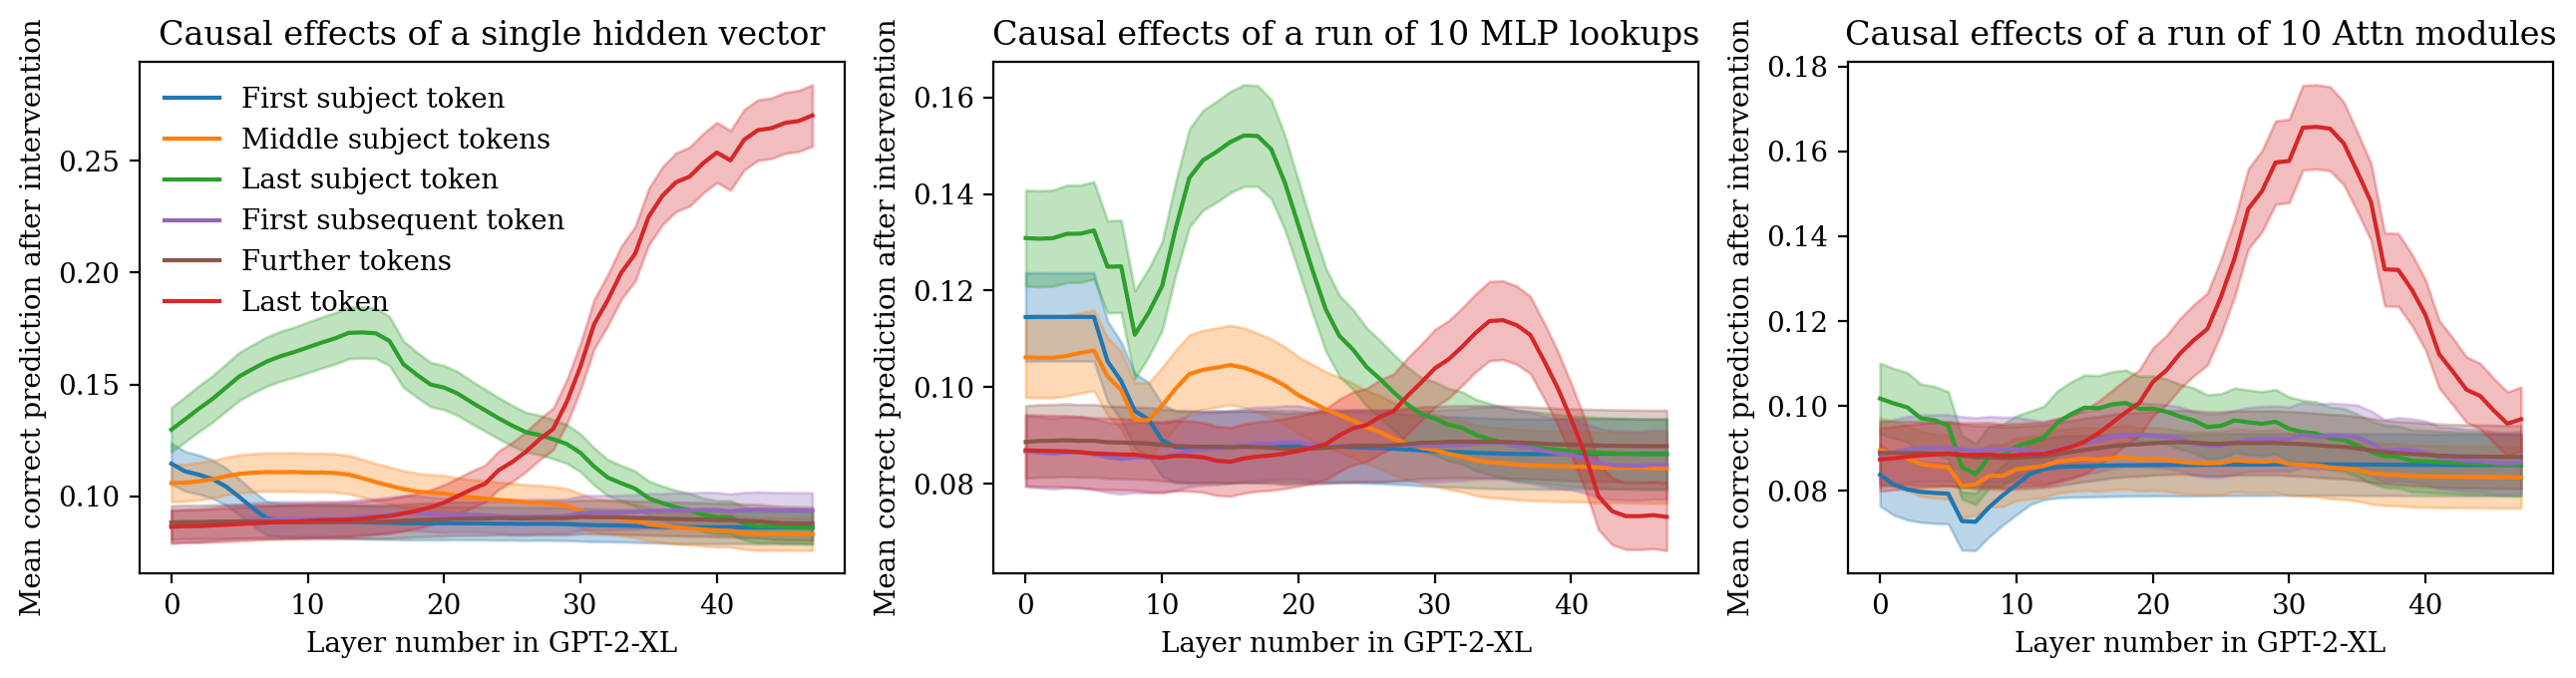

In [14]:
import math

labels = [
    "First subject token",
    "Middle subject tokens",
    "Last subject token",
    "First subsequent token",
    "Further tokens",
    "Last token",
]
color_order = [0, 1, 2, 4, 5, 3]
x = None

cmap = plt.get_cmap("tab10")
# fig, axes = plt.subplots(1, 3, figsize=(13, 3.5), sharey=True, dpi=200)
# for testing
fig, axes = plt.subplots(1, 3, figsize=(13, 3.5), sharey=False, dpi=200)
for j, (kind, title) in enumerate(
    [
        (None, "single hidden vector"),
        ("mlp", "run of 10 MLP lookups"),
        ("attn", "run of 10 Attn modules"),
    ]
):
    print(f"Reading {kind}")
    # d = read_knowlege(225, kind, arch)

    # for testing
    d = read_knowlege(the_count, kind, arch)

    for i, label in list(enumerate(labels)):
        # y = d["result"][i] - d["low_score"]
        # for testing
        y = d["result"][i]

        if x is None:
            x = list(range(len(y)))
        std = d["result_std"][i]
        error = std * 1.96 / math.sqrt(count)
        axes[j].fill_between(
            x, y - error, y + error, alpha=0.3, color=cmap.colors[color_order[i]]
        )
        axes[j].plot(x, y, label=label, color=cmap.colors[color_order[i]])

    # axes[j].set_title(f"Average indirect effect of a {title}")
    # axes[j].set_ylabel("Average indirect effect on p(o)")
    # axes[j].set_xlabel(f"Layer number in {archname}")
    # for testing
    axes[j].set_title(f"Causal effects of a {title}")
    axes[j].set_ylabel("Mean correct prediction after intervention")
    axes[j].set_xlabel(f"Layer number in {archname}")

    # axes[j].set_ylim(0.1, 0.3)
# axes[1].legend(frameon=False)
# for testing
axes[0].legend(frameon=False)

plt.tight_layout()
plt.savefig(f"results/{arch}/causal_trace/summary_pdfs/lineplot-causaltrace-prob-correct.pdf")
plt.show()